# BBBC021: Quality control

In [3]:
# %load ../common_.py
import sys
sys.path.append("../..")
from common import *

In [29]:
from aicsimageio.readers.tiff_glob_reader import TiffGlobReader

## Data

In [19]:
try:
    df = pq.read_table(snakemake.input[0]).to_pandas()
    
    if "image_root" in snakemake.config:
        image_root = Path(snakemake.config["image_root"])
        df["meta_path"] = df["meta_path"].apply(lambda p: image_root.joinpath(*Path(p).parts[Path(p).parts.index("images")+1:]))

    output_index = snakemake.output.index
    output_cols = snakemake.output.columns
except NameError:
    data_dir = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/BBBC021/scip/270520220947_Week1/")
    df = pq.read_table(data_dir / "features.parquet").to_pandas()
    output_index = data_dir / "indices/index.npy"
    output_cols = data_dir / "indices/columns.npy"

    image_root = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/BBBC021/images")
    df["meta_path"] = df["meta_path"].apply(lambda p: image_root.joinpath(*Path(p).parts[Path(p).parts.index("images")+1:]))

## No bounding box

In [21]:
# images that have no bounding box
df = df[~df.filter(regex="bbox").isna().any(axis=1)]
df.shape

(398569, 685)

## Number of regions

/apps/gent/RHEL8/zen2-ib/software/SciPy-bundle/2021.10-foss-2021b/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


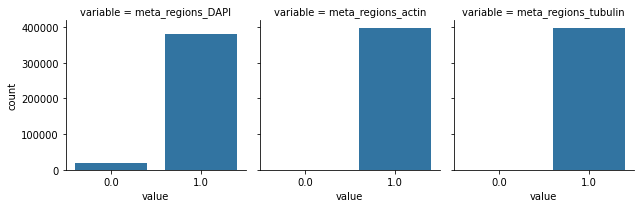

In [110]:
tmp = pandas.melt(df, value_vars=df.filter(regex="regions").columns)
tmp["value"] = tmp["value"].astype("category")
grid = seaborn.FacetGrid(data=tmp, col="variable")
grid.map_dataframe(seaborn.countplot, x="value")

## Detecting bad segmentations

In [97]:
def plot_tiff_gate(df, sel):
    r = df[sel].iloc[0]
    
    def map_to_index(f):
        idx = re.match("^.*_w([0-9]).*$", f).group(1)
        m = {"1": 0, "2": 1, "4": 2}
        return pandas.Series(
            dict(S=0, T=0, C=m[idx], Z=0)
        )

    im = TiffGlobReader(
        glob_in=sorted(glob.glob(re.match(r'(.*)w[0-9]', str(r["meta_path"])).groups()[0] + "w*.tif")),
        indexer=map_to_index,
        channel_names=["DAPI", "Actin", "Tubulin"]
    )
    pixels = im.get_image_data("CXY")
    
    minr, minc, maxr, maxc = int(r["meta_bbox_minr"]), int(r["meta_bbox_minc"]), int(r["meta_bbox_maxr"]), int(r["meta_bbox_maxc"])
    
    fig, axes = plt.subplots(1, len(pixels))
    for ax, p in zip(axes, pixels):
        ax.imshow(p[minr:maxr,minc:maxc])
        ax.set_axis_off()

<AxesSubplot:xlabel='feat_area_actin', ylabel='Count'>

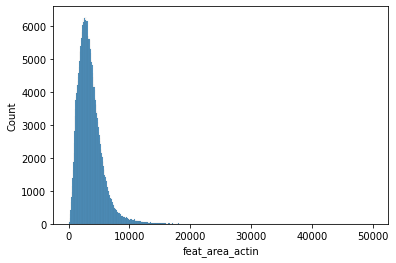

In [105]:
seaborn.histplot(data=df, x="feat_area_actin")

In [99]:
sel = df["feat_area_actin"] > 40000

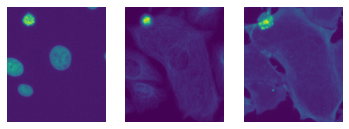

In [100]:
plot_tiff_gate(df, sel)

In [101]:
sel = df["feat_area_actin"] < 100

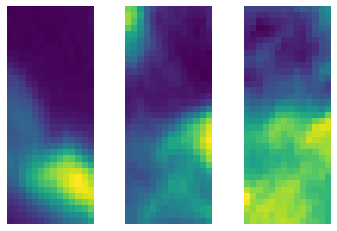

In [102]:
plot_tiff_gate(df, sel)

In [106]:
sel = df["feat_area_actin"] < 500

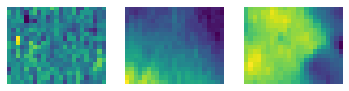

In [107]:
plot_tiff_gate(df, sel)